In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
from tqdm import tqdm
import os
import re

In [3]:
train = json.load(open('./input/cooking_train.json', 'r'))
test = json.load(open('./input/cooking_test.json', 'r'))

In [4]:
len(train)

30000

In [5]:
len(test)

9774

In [6]:
train[0]

{'cuisine': 'chinese',
 'id': 29565,
 'ingredients': ['romaine lettuce',
  'sliced almonds',
  'vegetable oil',
  'scallions',
  'soy sauce',
  'cooked chicken',
  'napa cabbage',
  'chopped cilantro fresh',
  'sugar',
  'sesame seeds',
  'wonton wrappers',
  'fresh lemon juice',
  'white vinegar',
  'black pepper',
  'sesame oil',
  'salt',
  'snow peas']}

In [7]:
all_data = train + test

# Class cardinality

In [8]:
labels = pd.Series([recipe['cuisine'] for recipe in train], name='labels')

In [11]:
labels.groupby(labels).count().sort_values()

labels
brazilian        352
russian          360
jamaican         404
irish            498
filipino         564
british          600
moroccan         605
korean           616
vietnamese       620
spanish          741
greek            898
japanese        1076
cajun_creole    1160
thai            1164
french          1983
chinese         2014
indian          2285
southern_us     3280
mexican         4886
italian         5894
Name: labels, dtype: int64

Let's check how baseline LGBM handles the weaker classes.

### Generating model input

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy as sp

In [13]:
%%time
all_recipes = train + test
print(len(all_recipes))

39774
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 11.2 ms


In [15]:
vectorizer = TfidfVectorizer()
all_ingredients = [' '.join(r['ingredients']) for r in all_recipes]
all_vectors = vectorizer.fit_transform(all_ingredients)
print(type(all_vectors))
assert(len(all_recipes) == all_vectors.shape[0])
print(all_vectors.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(39774, 3010)


In [17]:
data = all_vectors
type(data)

scipy.sparse.csr.csr_matrix

In [18]:
cousine_names = [r['cuisine'] for r in train]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(cousine_names)
type(labels)

numpy.ndarray

In [19]:
train_data = data[:len(labels)]
test_data = data[len(labels):]

### Training the model

In [23]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

In [26]:
%%time
splitter = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
results = []
for fold, (train_idx_, eval_idx_) in enumerate(splitter.split(train_data, labels)):
    train_X_, train_y_ = train_data[train_idx_], labels[train_idx_]
    eval_X_, eval_y_ = train_data[eval_idx_], labels[eval_idx_]
    model_params = {
        'objective': 'multiclass',
        'n_estimators': 512,
        'num_class': len(np.unique(labels)),
        'n_jobs': 12,
        'random_state': 42,
        'silent': True,
    }
    fit_params = {
        'eval_set': (eval_X_, eval_y_),
        'eval_metric': 'multi_error',
        'early_stopping_rounds': 64,
        'verbose': 16,
    }
    model = LGBMClassifier(**model_params)
    model.fit(train_X_, train_y_, **fit_params)
    preds = model.predict(eval_X_, num_iteration=model.best_iteration_)
    score = accuracy_score(eval_y_, preds)
    conf_mat = confusion_matrix(eval_y_, preds)
    print(f"Fold {fold}, val_accuracy={score}")
    results.append({
        'score': score,
        'model': model,
        'confusion_matrix': conf_mat
    })

Training until validation scores don't improve for 64 rounds.
[16]	valid_0's multi_error: 0.302019	valid_0's multi_logloss: 1.27945
[32]	valid_0's multi_error: 0.270738	valid_0's multi_logloss: 1.02053
[48]	valid_0's multi_error: 0.251549	valid_0's multi_logloss: 0.903704
[64]	valid_0's multi_error: 0.241555	valid_0's multi_logloss: 0.842804
[80]	valid_0's multi_error: 0.234559	valid_0's multi_logloss: 0.810366
[96]	valid_0's multi_error: 0.228063	valid_0's multi_logloss: 0.792748
[112]	valid_0's multi_error: 0.225565	valid_0's multi_logloss: 0.7842
[128]	valid_0's multi_error: 0.223466	valid_0's multi_logloss: 0.781122
[144]	valid_0's multi_error: 0.223566	valid_0's multi_logloss: 0.78061
[160]	valid_0's multi_error: 0.224066	valid_0's multi_logloss: 0.782541
[176]	valid_0's multi_error: 0.222067	valid_0's multi_logloss: 0.785991
[192]	valid_0's multi_error: 0.220668	valid_0's multi_logloss: 0.790731
Early stopping, best iteration is:
[137]	valid_0's multi_error: 0.223266	valid_0's mu

In [35]:
def plot_confusion_matrix(cm, labels = label_encoder.classes_):
    """ Taken from: https://www.kaggle.com/georsara1/light-gbm-solution-for-credit-fraud-detection """
    plt.figure()
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

<Figure size 432x288 with 0 Axes>

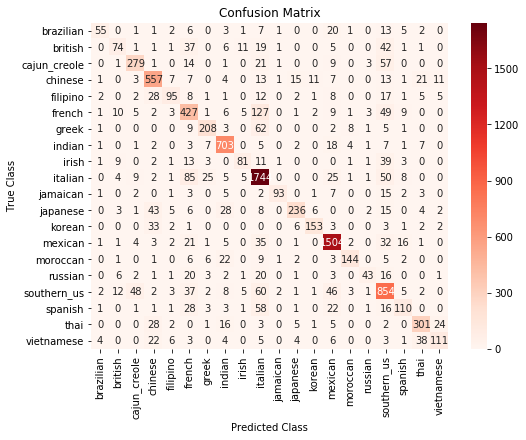

<Figure size 432x288 with 0 Axes>

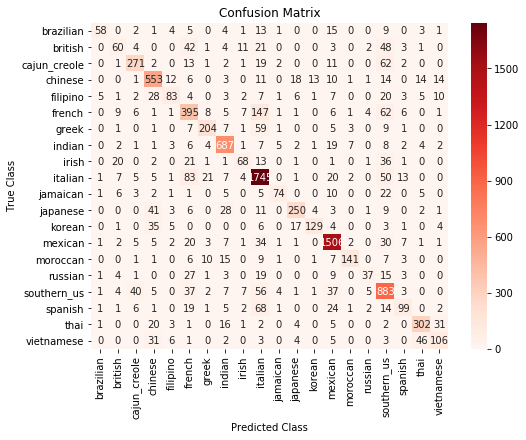

<Figure size 432x288 with 0 Axes>

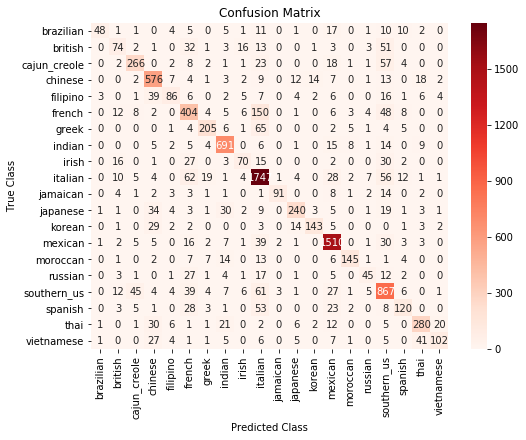

In [36]:
for md in results:
    plot_confusion_matrix(md['confusion_matrix'])

# Class-based ensembling strategies

### Training binary classifier for each of the classes

In [73]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [44]:
preds = np.array([1,0,0,1])
y = np.array([0,1,1,1])
preds != y

array([ True,  True,  True, False])

In [75]:
train_data.shape, labels.shape, labels_binarized.shape

((30000, 3010), (30000,), (30000,))

In [78]:
%%time
unique_labels = np.unique(labels)
binary_results = []
for selected_label in unique_labels:
    label_name = label_encoder.inverse_transform([selected_label])[0]
    print(f"Processing {label_name}...")
    labels_binarized = (labels == selected_label).astype(np.int)
    train_X_, eval_X_, train_y_, eval_y_ = train_test_split(
        train_data, 
        labels_binarized, 
        test_size=0.2, 
        shuffle=True, 
        stratify=labels, 
        random_state=42
    )
    X_resampled, y_resampled = SMOTE().fit_resample(train_X_, train_y_)
    model_params = {
        'objective': 'binary',
        'n_estimators': 256,
        'learning_rate': 0.00002137,
        'n_jobs': 8,
        'random_state': 42,
        'silent': True,
    }
    fit_params = {
        'eval_set': (eval_X_, eval_y_),
        'eval_metric': 'binary_error',
        'early_stopping_rounds': 64,
        'verbose': 8,
    }
    # fit and calculate score
    model = LGBMClassifier(**model_params)
    model.fit(X_resampled, y_resampled, **fit_params)
    preds = model.predict(eval_X_, num_iteration=model.best_iteration_)
    score = accuracy_score(eval_y_, preds)
    # find the labels often confused with the current one
    full_preds = model.predict(train_data)  # full data or no info about labels' names
    confused_labels, confused_counts = np.unique(labels[full_preds != labels_binarized], return_counts=True)
    print(f"Binary classfier for label {label_name}, val_accuracy={score}")
    binary_results.append({
        'label': label_name,
        'model': model,
        'score': score,
        'confused_with': {label: count for label, count in zip(confused_labels, confused_counts)}
    })

Processing brazilian...
Training until validation scores don't improve for 64 rounds.
[8]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.693015
[16]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692883
[24]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692751
[32]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692619
[40]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692487
[48]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692355
[56]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692223
[64]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.692091
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.09	valid_0's binary_logloss: 0.693131
Binary classfier for label brazilian, val_accuracy=0.91
Processing british...
Training until validation scores don't improve for 64 rounds.
[8]	valid_0's binary_error: 0.134167	valid_0's binary_logloss: 0.693032
[16]	valid_0's binary_error: 0.134167	valid_0's 

KeyboardInterrupt: 

In [67]:
model = binary_results[0]['model']

### Training pairwise classifiers to distinguish similar ingredients

In [ ]:
for i, label_1 in enumerate(unique_labels):
    for label_2 in unique_labels[i:]:
        label_name = label_encoder.inverse_transform([selected_label])[0]
        print(f"Processing {label_name}...")
        labels_binarized = (labels == selected_label).astype(np.int)
        train_X_, eval_X_, train_y_, eval_y_ = train_test_split(
            train_data, 
            labels_binarized, 
            test_size=0.2, 
            shuffle=True, 
            stratify=labels, 
            random_state=42
        )
        model_params = {
            'objective': 'multiclass',
            'n_estimators': 512,
            'num_class': len(np.unique(labels)),
            'n_jobs': 12,
            'random_state': 42,
            'silent': True,
        }
        fit_params = {
            'eval_set': (eval_X_, eval_y_),
            'eval_metric': 'multi_error',
            'early_stopping_rounds': 64,
            'verbose': 16,
        }
        model = LGBMClassifier(**model_params)
        model.fit(train_X_, train_y_, **fit_params)
        preds = model.predict(eval_X_, num_iteration=model.best_iteration_)
        score = accuracy_score(eval_y_, preds)
        conf_mat = confusion_matrix(eval_y_, preds)
        print(f"Fold {fold}, val_accuracy={score}")
        results.append({
            'score': score,
            'model': model,
            'confusion_matrix': conf_mat
        })

### Selecting class groups to train separate models on
The idea is to train the models that distinguish particular classes better than the general model.
To do this, we will for each class select other classes that are often confused with it.

# Building a basic ensemble